In [1]:
# IPython magic to import matplotlib and plot inline
%matplotlib inline

from fenics import *

In [2]:
# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

In [3]:
# Create mesh and define function space
mesh = UnitCubeMesh(24, 16, 16)
V = VectorFunctionSpace(mesh, "Lagrange", 1)

In [4]:
# Mark boundary subdomians
left =  CompiledSubDomain("near(x[0], side) && on_boundary", side = 0.0)
right = CompiledSubDomain("near(x[0], side) && on_boundary", side = 1.0)

In [5]:
# Define Dirichlet boundary (x = 0 or x = 1)
c = Expression(("0.0", "0.0", "0.0"), degree = 0)
r = Expression(("scale*0.0",
                "scale*(y0 + (x[1] - y0)*cos(theta) - (x[2] - z0)*sin(theta) - x[1])",
                "scale*(z0 + (x[1] - y0)*sin(theta) + (x[2] - z0)*cos(theta) - x[2])"),
                scale = 0.5, y0 = 0.5, z0 = 0.5, theta = pi/3, degree = 1)

bcl = DirichletBC(V, c, left)
bcr = DirichletBC(V, r, right)
bcs = [bcl, bcr]

In [6]:
# Define functions
du = TrialFunction(V)            # Incremental displacement
v  = TestFunction(V)             # Test function
u  = Function(V)                 # Displacement from previous iteration
B  = Constant((0.0, -0.5, 0.0))  # Body force per unit volume
T  = Constant((0.1,  0.0, 0.0))  # Traction force on the boundary

In [7]:
# Kinematics
d = u.geometric_dimension()
I = Identity(d)             # Identity tensor
F = I + grad(u)             # Deformation gradient
C = F.T*F                   # Right Cauchy-Green tensor


In [8]:
# Invariants of deformation tensors
Ic = tr(C)
J  = det(F)

In [9]:
# Elasticity parameters
E, nu = 10.0, 0.3
mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))

In [10]:
# Stored strain energy density (compressible neo-Hookean model)
psi = (mu/2)*(Ic - 3) - mu*ln(J) + (lmbda/2)*(ln(J))**2

In [21]:
# Total potential energy
Pi = psi*dx - dot(B, u)*dx - dot(T, u)*ds

In [22]:
# Compute first variation of Pi (directional derivative about u in the direction of v)
F = derivative(Pi, u, v)

In [23]:
# Compute Jacobian of F
J = derivative(F, u, du)

In [24]:
# Solve variational problem
solve(F == 0, u, bcs, J=J,
      form_compiler_parameters=ffc_options)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


KeyboardInterrupt: 

In [15]:
# Save solution in VTK format
file = File("displacement.pvd");
file << u;

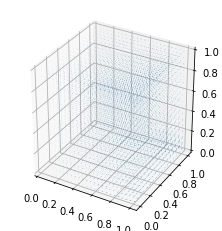

In [16]:
# Plot and hold solution
plot(u, mode = "displacement", interactive = True)
plot(u)